In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# !unzip -uq '/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/qQWE2qsac.zip' -d '/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/raw_image'

In [ ]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 16

# Training 수
epochs = 30

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [ ]:
# !pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# input_dir = "/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/raw_image/"
# output_dir = "/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/data/"

In [ ]:
# import splitfolders
# splitfolders.ratio(input_dir, output_dir, seed=77, ratio=(.9,.1) )

Copying files: 12559 files [06:16, 33.33 files/s] 


In [ ]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/data/"

train_directory = CurrentDirectory + 'train/'
test_directory  = CurrentDirectory + 'test/'
model_directory = CurrentDirectory + 'Model/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [ ]:
os.listdir(test_directory), os.listdir(train_directory)

(['Benign', 'Cancer'], ['Benign', 'Cancer'])

In [ ]:
# 모델 Return
VGGModel = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(VGGModel.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning = Model(inputs=VGGModel.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE


58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
VGGModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [ ]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 10172 images belonging to 2 classes.
Found 1130 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.


In [ ]:
TEST_GENERATOR.__getitem__(0)[1]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'VGG16-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14268896199064677300
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8977004279785199038
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
########## Training Start
with tf.device("/device:GPU:0"):
    history = DeepLearning.fit(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        epochs=epochs,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
636/635 [==============================] - ETA: 0s - loss: 0.4834 - acc: 0.7950
Epoch 1: val_acc did not improve from 0.78850
635/635 [==============================] - 213s 335ms/step - loss: 0.4834 - acc: 0.7950 - val_loss: 0.5236 - val_acc: 0.7885 - lr: 0.0010
Epoch 2/30
636/635 [==============================] - ETA: 0s - loss: 0.4465 - acc: 0.8132
Epoch 2: val_acc improved from 0.78850 to 0.79381, saving model to /content/drive/MyDrive/Colab Notebooks/03_MultiCenter/data/Model/VGG16-002-0.5505-0.7938.hdf5
635/635 [==============================] - 210s 330ms/step - loss: 0.4465 - acc: 0.8132 - val_loss: 0.5505 - val_acc: 0.7938 - lr: 0.0010
Epoch 3/30
636/635 [==============================] - ETA: 0s - loss: 0.4221 - acc: 0.8199
Epoch 3: val_acc did not improve from 0.79381
635/635 [==============================] - 211s 332ms/step - loss: 0.4221 - acc: 0.8199 - val_loss: 0.4836 - val_acc: 0.7938 - lr: 0.0010
Epoch 4/30
636/635 [==============================] - ETA: 0

In [ ]:
DeepLearning.evaluate(VALID_GENERATOR)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


71/71 [==============================] - 20s 284ms/step - loss: 0.5153 - acc: 0.8097


[0.5153234004974365, 0.8097345232963562]

In [ ]:
os.listdir(model_directory)

['VGG16-001-0.5171-0.7885.hdf5',
 'VGG16-002-0.5505-0.7938.hdf5',
 'VGG16-004-0.4666-0.8115.hdf5',
 'VGG16-008-0.4605-0.8124.hdf5',
 'VGG16-012-0.4617-0.8177.hdf5',
 'VGG16-017-0.4625-0.8204.hdf5',
 'VGG16-021-0.4519-0.8257.hdf5']

In [ ]:
DeepLearning.load_weights(model_directory+'VGG16-021-0.4519-0.8257.hdf5')

In [ ]:
DeepLearning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


79/79 [==============================] - 279s 4s/step


In [ ]:
Result = pd.DataFrame(TEST_Prediction)

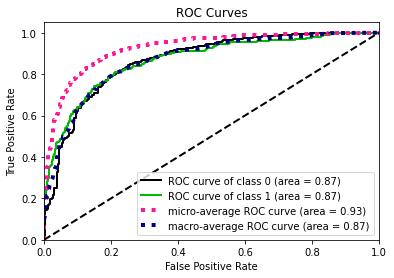

In [ ]:
skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result)

In [ ]:
import PIL

def grad_cam(model, img, layer_name="block5_conv3", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [ ]:
# CAM Generator
CAM_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = 1,
    shuffle = False,
    class_mode='binary')

Found 1257 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[0.]


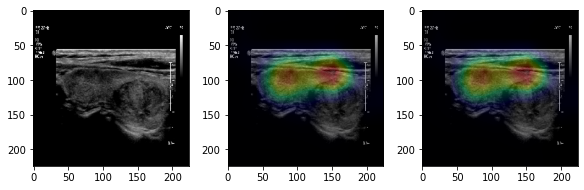

In [ ]:
Iterator = 535

# item 받아오기
Image, Label = CAM_GENERATOR.__getitem__(Iterator)
Image = Image[0]
print(Label)


# grad_cam을 활용하여 heatmap 가져오기
HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'block5_conv3', category_id=0)
heatmap_resize = cv2.resize(HEATMAP1, (224, 224))
heatmap_resize_255 = (heatmap_resize*255).astype("uint8")
heatmap1 = cv2.applyColorMap(255-heatmap_resize_255, cv2.COLORMAP_JET ) / 255
heatmap1[:, :, 2] -= .5
heatmap1[(heatmap1[:, :, 2] < 0), 2] = 0

fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
fig.set_size_inches(9.0, 3.0)
ax = plt.subplot(1,3,1)
ax.imshow(Image)
ax = plt.subplot(1,3,2)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
ax = plt.subplot(1,3,3)
ax.imshow(Image)
ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
pred=round(pred1.numpy()[0][0],3)
plt.show()